# Examining how traits affect the number of insects associated with plants. 

- 01: Data cleaning
- 02a: ML exploration for Cvalue predictors
- **02b: ML exploration for No_bugs predictors**
- 04: build a new phylogeny
- 03a: PGLS phylogenetic controlled comparison for CVal
- 03b: PGLS phylogenetic controlled comparison for No_bugs

In [50]:
# install seaborn
# %pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('./data/cleaned_20240729')
df['log_long_val'] = np.log(df['long_val'])

print(df.columns)
print(df.shape)

Index(['plant_no', 'long_val', 'soil_nutr_val', 'leafP_val', 'leafN_val',
       'clonality_state', 'dicliny_val', 'plant_name', 'genus', 'family',
       'Cval', 'No_bugs', 'log_long_val'],
      dtype='object')
(1736, 13)


In [51]:
# Create a boolean mask where the original list is not NaN
mask = ~pd.isna(df['No_bugs'])

# Apply the mask to the DataFrame to keep corresponding rows
df = df[mask]

# Display the filtered DataFrame and list
df

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val
0,260070070,100.0,0.0,1.0,10.0,1,3.0,PINUS SYLVESTRIS,PINUS,PINACEAE,NaN,65.0,4.605170
1,280050020,100.0,0.0,1.0,10.0,1,1.0,JUNIPERUS COMMUNIS,JUNIPERUS,CUPRESSACEAE,NaN,16.0,4.605170
2,290010010,500.0,3.0,1.0,10.0,1,1.0,TAXUS BACCATA,TAXUS,TAXACEAE,NaN,25.0,6.214608
3,310010590,NaN,1.0,NaN,NaN,1,1.0,SALIX LAPPONUM,SALIX,SALICACEAE,NaN,3.0,NaN
4,310020020,NaN,NaN,NaN,NaN,0,1.0,POPULUS X CANESCENS,POPULUS,SALICACEAE,NaN,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1990120740,NaN,NaN,NaN,NaN,2,3.0,CAREX PANICEA,CAREX,CYPERACEAE,NaN,2.0,NaN
1690,1990121090,NaN,NaN,NaN,NaN,1,3.0,CAREX HUMILIS,CAREX,CYPERACEAE,NaN,1.0,NaN
1706,1990121640,NaN,NaN,NaN,NaN,1,3.0,CAREX ELATA,CAREX,CYPERACEAE,NaN,2.0,NaN
1707,1990121670,NaN,NaN,NaN,NaN,2,3.0,CAREX NIGRA,CAREX,CYPERACEAE,NaN,3.0,NaN


In [48]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# compare min max scaling to standard scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import shap
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscoreimport pandas as pd
import numpy as np
import xgboost as xgb

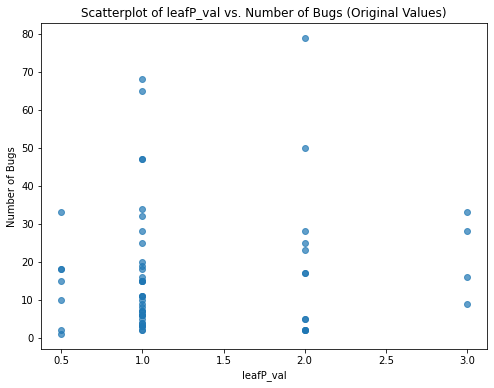

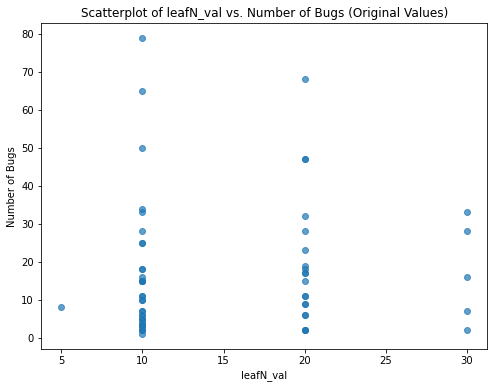

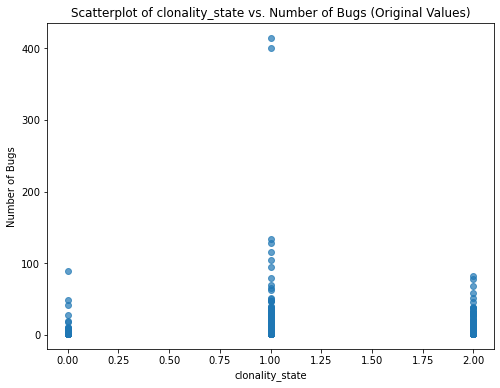

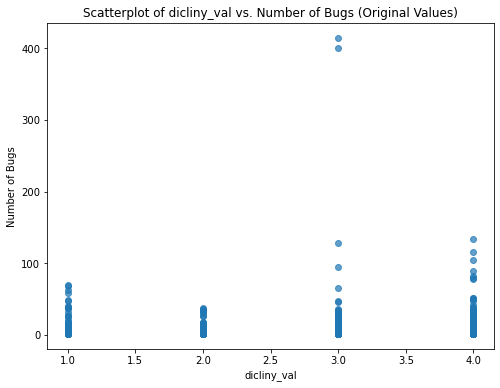

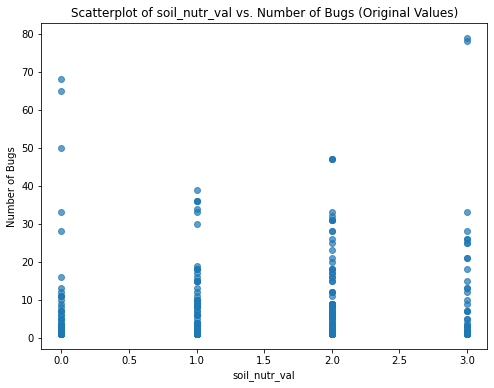

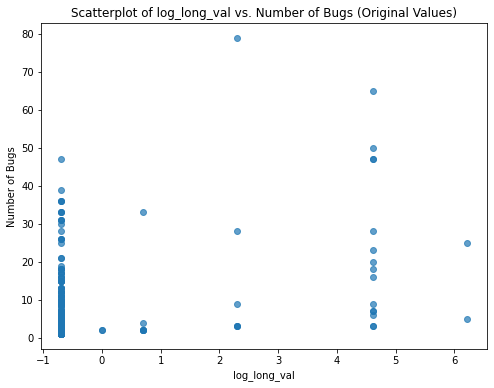

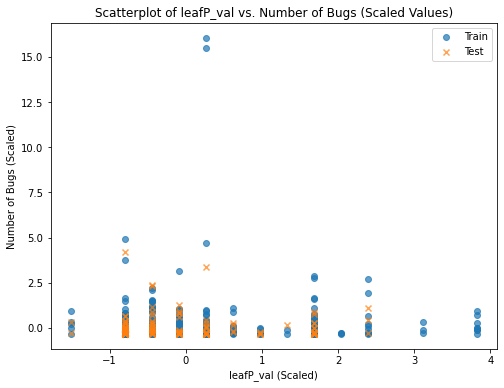

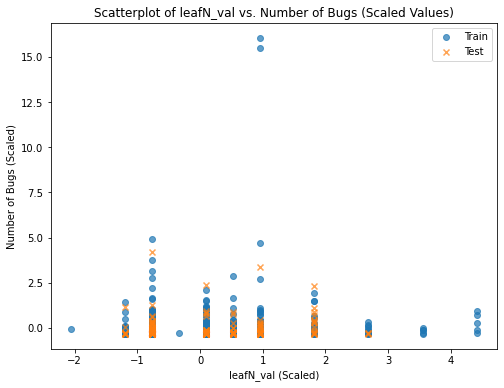

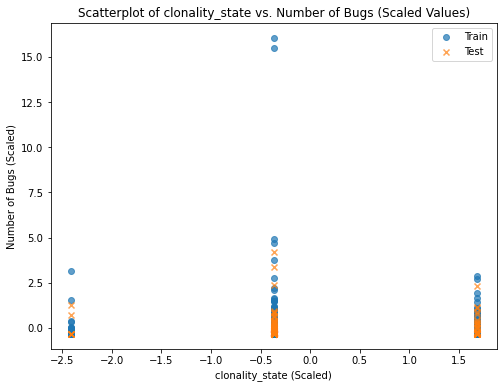

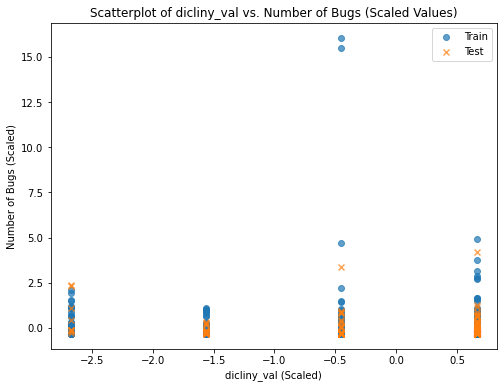

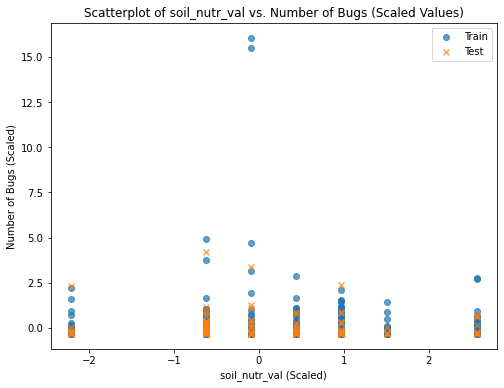

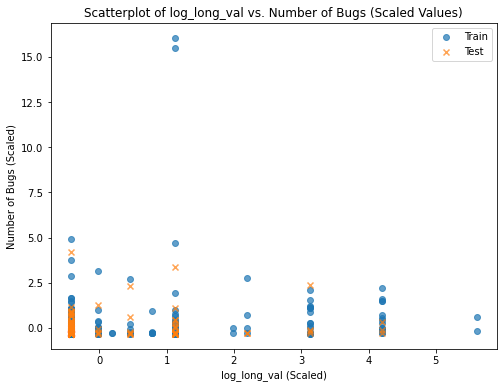

In [52]:
indepVar = ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']


# Independent variables and target
target = 'No_bugs'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[indepVar], df[target], test_size=0.2, random_state=42)

# Create a pipeline with KNN imputer and standard scaler for independent variables
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Impute missing values
    ('scaler', StandardScaler()),  # Standardize features
    ('model', xgb.XGBRegressor())  # Model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Extract the model from the pipeline
model = pipeline.named_steps['model']

# Transform the data using the fitted pipeline (excluding the model step)
X_train_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_train))
X_test_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_test))

# Convert y_train and y_test to NumPy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Scale the target variable using StandardScaler
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Convert scaled arrays to DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=indepVar)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=indepVar)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=['No_bugs'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['No_bugs'])

# Plot scatterplots for each independent variable vs. the target variable (original values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[var], df['No_bugs'], alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Number of Bugs')
    plt.title(f'Scatterplot of {var} vs. Number of Bugs (Original Values)')
    plt.show()

# Plot scatterplots for each independent variable vs. the target variable (scaled values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_scaled_df[var], y_train_scaled_df['No_bugs'], alpha=0.7, label='Train')
    plt.scatter(X_test_scaled_df[var], y_test_scaled_df['No_bugs'], alpha=0.7, label='Test', marker='x')
    plt.xlabel(f'{var} (Scaled)')
    plt.ylabel('Number of Bugs (Scaled)')
    plt.title(f'Scatterplot of {var} vs. Number of Bugs (Scaled Values)')
    plt.legend()
    plt.show()


In [53]:
# Extract the model from the pipeline
model = pipeline.named_steps['model']

# Predictions
y_pred = model.predict(X_test)

# Metrics

def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - n_features - 1))
    return adj_r2
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2_score(y_test, y_pred, X_test.shape[1])
explained_variance = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")
print(f"Explained Variance Score: {explained_variance}")
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Squared Error: 350.69703567127783
Root Mean Squared Error: 18.726906729924135
Mean Absolute Error: 10.933481069688481
R-squared: -0.5520407833542571
Adjusted R-squared: -0.6078027276663862
Explained Variance Score: -0.5502269603897789
Mean Absolute Percentage Error: 313.3906821572834%


In [54]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


           Feature  Importance
5     log_long_val    0.668207
4    soil_nutr_val    0.091889
0        leafP_val    0.072130
2  clonality_state    0.064634
3      dicliny_val    0.055365
1        leafN_val    0.047775


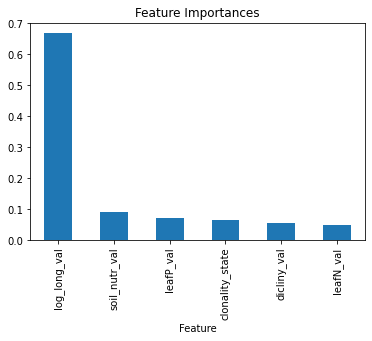

In [55]:
# # Print feature importances
# print("Feature Importances:", model.feature_importances_)
# print("The features are:", indepVar)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': indepVar,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, title='Feature Importances')
plt.show()



You are using an XGBoost version below 1.6.0 which is not fully supported by shap. Shap falls back to encoding the model as JSON which can lead to numerical precision issues. Please consider upgrading to XGBoost 1.6.0 or higher.


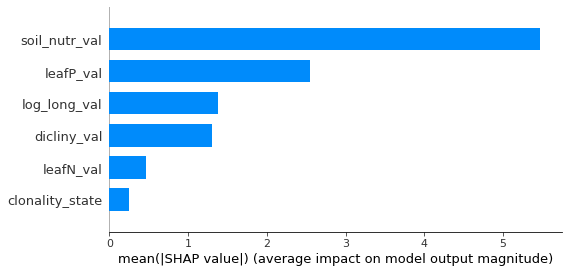

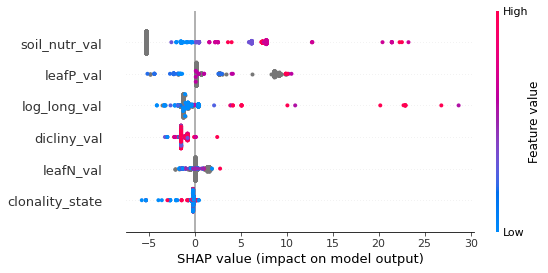

In [56]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df[indepVar])
shap.summary_plot(shap_values, df[indepVar], plot_type='bar')
shap.summary_plot(shap_values, df[indepVar])

# shap.decision_plot()


### To do:
1. Do we need to transform (already scaled) number of bugs? 
   1. Tried multiple scalers (minmax and standard to same result)
   2. and/or remove any outliers in no bugs? and/or longevity?
2. Other, clever feature engineering approaches (some combination of nutrition?)

In [57]:
# Calculate Z-scores for the target variable
df['bugs_zscore'] = zscore(df['No_bugs'])
df['long_zscore'] = zscore(df['log_long_val'])

# Identify outliers (e.g., Z-score > 3 or < -3)
outliers_b = df[np.abs(df['bugs_zscore']) > 3]
outliers_l = df[np.abs(df['long_zscore']) > 3]
print(len(outliers_b))
print(len(outliers_l))# print colnames


print(outliers_b)

9
0
        plant_no  long_val  soil_nutr_val  leafP_val  leafN_val  \
652    340010010       NaN            NaN        NaN        NaN   
653    340010020       NaN            NaN        NaN        NaN   
654    360030120       NaN            NaN        NaN        NaN   
655    360030150       NaN            NaN        NaN        NaN   
979    800270030       NaN            NaN        NaN        NaN   
985    800350080       NaN            NaN        NaN        NaN   
1045   810590070       NaN            NaN        NaN        NaN   
1106  1050010050       NaN            NaN        NaN        NaN   
1448  1691180280       NaN            NaN        NaN        NaN   

      clonality_state  dicliny_val          plant_name    genus      family  \
652                 1          3.0      BETULA PENDULA   BETULA  BETULACEAE   
653                 1          3.0    BETULA PUBESCENS   BETULA  BETULACEAE   
654                 1          3.0     QUERCUS PETRAEA  QUERCUS    FAGACEAE   
655      

In [58]:
# 4 that have values > 3
# drop those
# Remove outliers from the DataFrame
df_cleaned = df[np.abs(df['bugs_zscore']) <= 3]

# Drop the Z-score column as it's no longer needed
df_cleaned = df_cleaned.drop(columns=['bugs_zscore'])

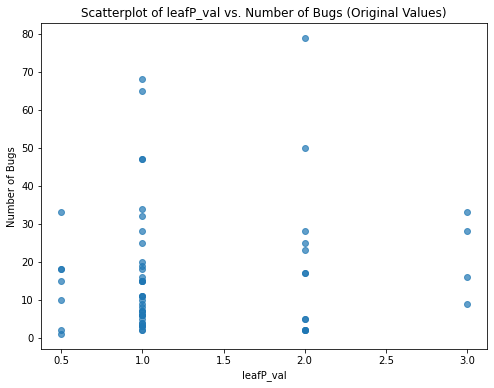

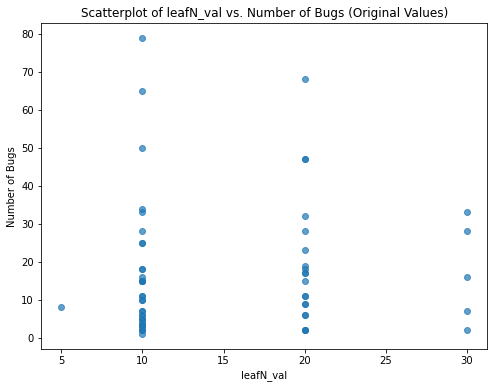

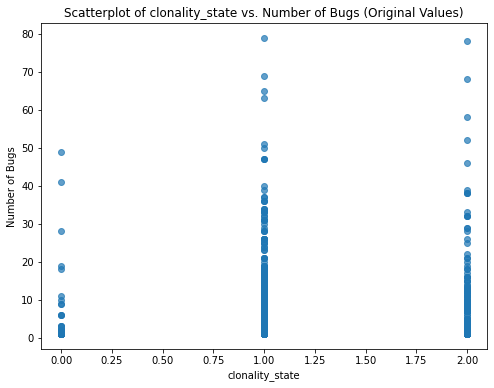

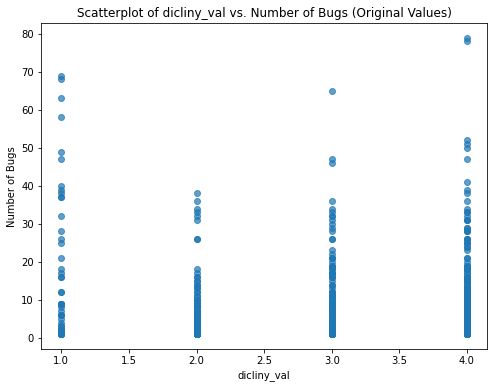

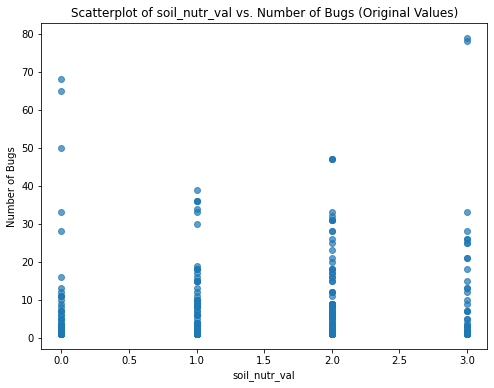

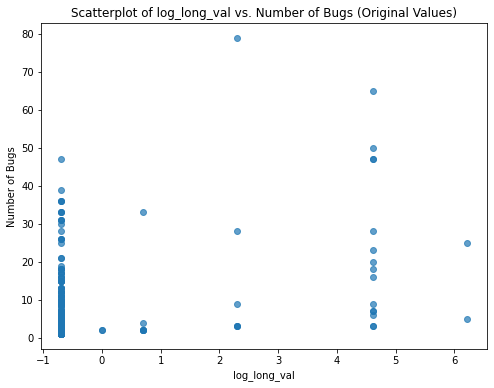

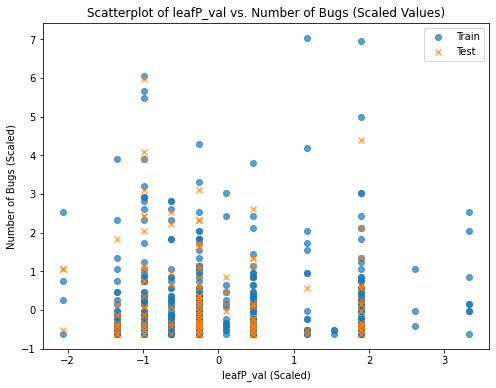

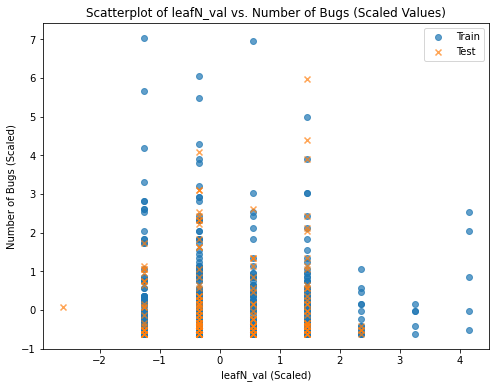

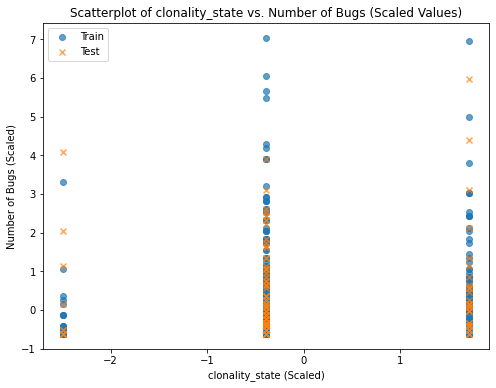

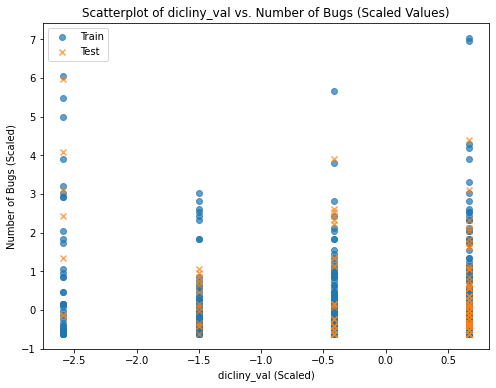

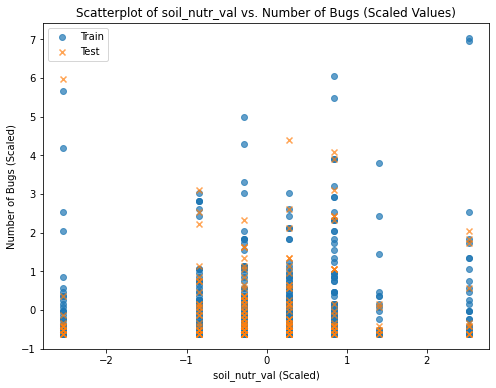

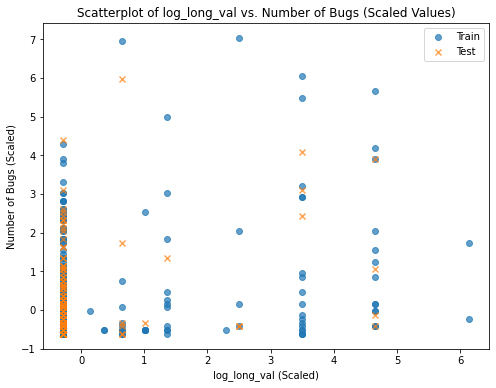

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned[indepVar], df_cleaned[target], test_size=0.2, random_state=42)

# Create a pipeline with KNN imputer and standard scaler for independent variables
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Impute missing values
    ('scaler', StandardScaler()),  # Standardize features
    ('model', xgb.XGBRegressor())  # Model
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Extract the model from the pipeline
model = pipeline.named_steps['model']

# Transform the data using the fitted pipeline (excluding the model step)
X_train_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_train))
X_test_scaled = pipeline.named_steps['scaler'].transform(pipeline.named_steps['imputer'].transform(X_test))

# Convert y_train and y_test to NumPy arrays
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Scale the target variable using StandardScaler
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Convert scaled arrays to DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=indepVar)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=indepVar)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=['No_bugs'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['No_bugs'])

# Plot scatterplots for each independent variable vs. the target variable (original values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cleaned[var], df_cleaned['No_bugs'], alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Number of Bugs')
    plt.title(f'Scatterplot of {var} vs. Number of Bugs (Original Values)')
    plt.show()

# Plot scatterplots for each independent variable vs. the target variable (scaled values)
for var in indepVar:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_scaled_df[var], y_train_scaled_df['No_bugs'], alpha=0.7, label='Train')
    plt.scatter(X_test_scaled_df[var], y_test_scaled_df['No_bugs'], alpha=0.7, label='Test', marker='x')
    plt.xlabel(f'{var} (Scaled)')
    plt.ylabel('Number of Bugs (Scaled)')
    plt.title(f'Scatterplot of {var} vs. Number of Bugs (Scaled Values)')
    plt.legend()
    plt.show()



In [60]:
# Extract the model from the pipeline
model = pipeline.named_steps['model']

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2_score(y_test, y_pred, X_test.shape[1])
explained_variance = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")
print(f"Explained Variance Score: {explained_variance}")
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Squared Error: 253.70881788910535
Root Mean Squared Error: 15.928239635600205
Mean Absolute Error: 11.39618526166574
R-squared: -1.0056406507968507
Adjusted R-squared: -1.078133686367821
Explained Variance Score: -0.99505045492813
Mean Absolute Percentage Error: 338.223889060524%


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
           Feature  Importance
5     log_long_val    0.486077
4    soil_nutr_val    0.148500
2  clonality_state    0.116074
3      dicliny_val    0.100349
1        leafN_val    0.080571
0        leafP_val    0.068429


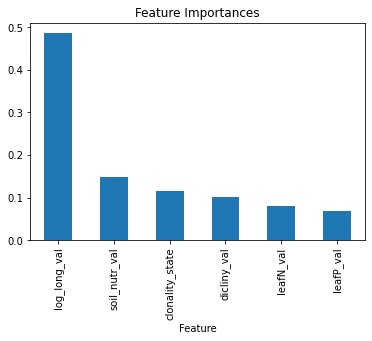

You are using an XGBoost version below 1.6.0 which is not fully supported by shap. Shap falls back to encoding the model as JSON which can lead to numerical precision issues. Please consider upgrading to XGBoost 1.6.0 or higher.


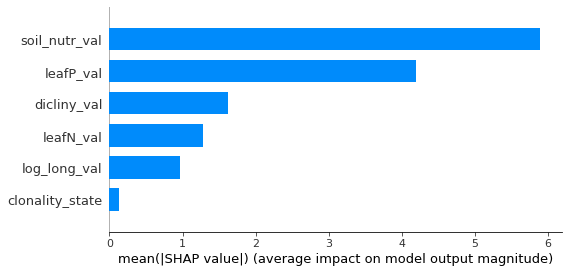

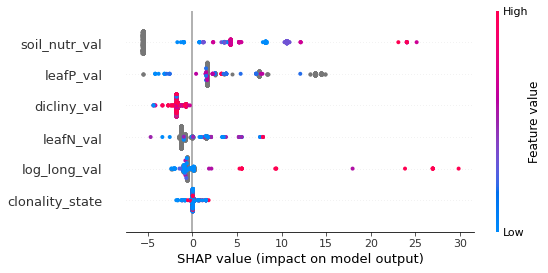

In [61]:
print(model)
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': indepVar,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Visualize feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, title='Feature Importances')
plt.show()


explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df[indepVar])
shap.summary_plot(shap_values, df[indepVar], plot_type='bar')
shap.summary_plot(shap_values, df[indepVar])

# shap.decision_plot()


### Outstanding questions.
1. Why do importance measures differ from SHAP impact?
2. How do we account for phylogenetic non-independence? 
   1. Go to `R` and use `ape` or https://lukejharmon.github.io/pcm/pdf/phylogeneticComparativeMethods.pdf to understand PGLS. I don't think this can work on more than one variable. 
   2. Need the tree. Presumably at the genus level. Average within genus?